In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

from numpy.fft import fft, fftshift, fftfreq
from matplotlib import pyplot as plt
from pathlib import Path
import importlib

In [24]:
import helpers
importlib.reload(helpers)

# Driver
class Ex:
    def __init__(self, name: str, num_notes: int, spec_thresh: float, bpm: int, max_num_notes_per_beat: int):
        self.name = name
        self.num_notes = num_notes
        self.spec_thresh = spec_thresh
        self.bpm = bpm
        self.max_num_notes_per_beat = max_num_notes_per_beat
        self.min_time_between = 60 / (self.bpm * max_num_notes_per_beat)

exerciseNoteCounts = [
    # Ex("ex1WholeMod.mp4", num_notes=90, spec_thresh=.15, bpm=80, max_num_notes_per_beat=2),
    # Ex("ex1WholeModF.mp4", num_notes=90, spec_thresh=.15, bpm=120, max_num_notes_per_beat=2),
    Ex("ex2WholeMod.mp4", num_notes=49, spec_thresh=.15, bpm=80, max_num_notes_per_beat=1),
    # Ex("ex3WholeMod.mp4", num_notes=145, spec_thresh=.15, bpm=100, max_num_notes_per_beat=2),
    # Ex("ex3WholeModF.mp4", num_notes=145, spec_thresh=.15, bpm=130, max_num_notes_per_beat=2),
    # Ex("ex4WholeMod.mp4", num_notes=102, spec_thresh=.15, bpm=90, max_num_notes_per_beat=4),
    # Ex("ex4WholeModF.mp4", num_notes=102, spec_thresh=.05, bpm=120, max_num_notes_per_beat=2),
    # Ex("ex5WholeMod.mp4", num_notes=133, spec_thresh=.15, bpm=64, max_num_notes_per_beat=2),
    # Ex("ex5WholeModF.mp4", num_notes=133, spec_thresh=.15, bpm=86, max_num_notes_per_beat=2),
    Ex("ex6WholeMod.mp4", num_notes=118, spec_thresh=.15, bpm=70, max_num_notes_per_beat=4),
    Ex("ex6WholeModF.mp4", num_notes=118, spec_thresh=.15, bpm=90, max_num_notes_per_beat=4),
    Ex("ex7WholeMod.mp4", num_notes=86, spec_thresh=.15, bpm=70, max_num_notes_per_beat=2),
    Ex("ex8WholeMod.mp4", num_notes=112, spec_thresh=.15, bpm=55, max_num_notes_per_beat=4),
    Ex("ex8WholeModF.mp4", num_notes=112, spec_thresh=.15, bpm=80, max_num_notes_per_beat=4),
    Ex("ex9WholeMod.mp4", num_notes=121, spec_thresh=.15, bpm=100, max_num_notes_per_beat=4),
    Ex("ex10WholeMod.mp4", num_notes=102, spec_thresh=.15, bpm=120, max_num_notes_per_beat=3)
]

for ex in exerciseNoteCounts:
    exercise = ex.name
    note_count = ex.num_notes
    spec_thresh = ex.spec_thresh
    min_time_between = ex.min_time_between * .8

    ys, ts, sr = helpers.get_audio_data(f"exercises/{exercise}")
    ts_fr, fr_freq_amps, freq_bins = helpers.magnitude_spectrogram(ys, ts, sr)
    ts_fr, spec_flux = helpers.compute_spectral_flux(ts_fr, fr_freq_amps, sr)

    centroids = helpers.compute_spectral_centroid(time_frames=ts_fr, freq_bins=freq_bins, frame_freq_amps=fr_freq_amps)

    
    plt.title(exercise)
    plt.xlabel("Time (s)"); plt.ylabel("Spectral Flux")
    plt.plot(ts_fr, spec_flux, c="orange")
    img_path = Path.cwd() / "spec_flux_graphs" / f"{exercise} Spectral Flux.png"
    if exercise == 'ex4WholeModF.mp4':
        plt.xlim((5, 9))
    plt.savefig(img_path)
    plt.close()
    
    # f0_frame_size = 2048
    # f0_hop_len = 512
    # f0, voiced, _ = librosa.pyin(y=ys, sr=sr, fmin=librosa.note_to_hz('E3'), fmax=librosa.note_to_hz('C6'), frame_length=f0_frame_size, hop_length=f0_hop_len)
    # f0 = gaussian_filter1d(f0, sigma=1)


    # onsets = helpers.detect_onsets(spec_flux, ts_fr, threshold=spec_thresh, min_time_between=min_time_between)
    onsets, sustains = helpers.detect_onsets_and_release(spec_flux=spec_flux, times=ts_fr, sr=sr, onset_thresh=spec_thresh, min_time_between=min_time_between)

    print_num_onset_detection_accuracy = True
    graph_onsets_sustains = True
    graph_centroids = True
    
    if print_num_onset_detection_accuracy:
        print(f"For exercise {exercise}, Note count Actual:\t{note_count}, Note count Detected: \t{len(onsets)} | Accuracy: \t{min(note_count / len(onsets), len(onsets) / note_count)}")

    if graph_onsets_sustains:
        artic_lens = [sustains[i] - onsets[i] for i in range(min(len(onsets), len(sustains)))]
        if np.max(artic_lens) > 1:
            print("==============================================================")
            print(f"For {exercise}, min articulation length: {np.min(artic_lens)}")
            print(f"For {exercise}, max articulation length: {np.max(artic_lens)}")
        print(f"For {exercise}, mean articulation length: {np.average(artic_lens)}")

        onset_indic = np.zeros_like(ts_fr)
        sustain_indic = np.zeros_like(ts_fr)

        stem_top = np.max(centroids)

        # Set 1.0 at the closest time points where onsets/sustains occur
        for onset_time in onsets:
            idx = np.argmin(np.abs(ts_fr - onset_time))
            onset_indic[idx] = stem_top
            
        for sustain_time in sustains:
            idx = np.argmin(np.abs(ts_fr - sustain_time))
            sustain_indic[idx] = stem_top

        plt.title(f"{exercise} Onset + Sustain + Spectral Centroid")
        plt.xlim(10, 14)
        plt.xlabel("Times (s)")
        plt.stem(ts_fr, onset_indic, linefmt='--', markerfmt='pink', label='Onsets')
        plt.stem(ts_fr, sustain_indic, linefmt='--', markerfmt='red', label='Sustains')
        plt.legend()
        img_path = Path.cwd() / "centroids" / f"{exercise} centroid.png"
        plt.plot(ts_fr, centroids)
        plt.savefig(img_path)
        plt.close()

For exercise ex2WholeMod.mp4, Note count Actual:	49, Note count Detected: 	46 | Accuracy: 	0.9387755102040817
For ex2WholeMod.mp4, mean articulation length: 0.031086956521739116
For exercise ex6WholeMod.mp4, Note count Actual:	118, Note count Detected: 	118 | Accuracy: 	1.0
For ex6WholeMod.mp4, mean articulation length: 0.036694915254237445
For exercise ex6WholeModF.mp4, Note count Actual:	118, Note count Detected: 	118 | Accuracy: 	1.0
For ex6WholeModF.mp4, mean articulation length: 0.0391525423728811
For exercise ex7WholeMod.mp4, Note count Actual:	86, Note count Detected: 	83 | Accuracy: 	0.9651162790697675
For ex7WholeMod.mp4, mean articulation length: 0.03325301204819304
For exercise ex8WholeMod.mp4, Note count Actual:	112, Note count Detected: 	112 | Accuracy: 	1.0
For ex8WholeMod.mp4, mean articulation length: 0.03625000000000016
For exercise ex8WholeModF.mp4, Note count Actual:	112, Note count Detected: 	112 | Accuracy: 	1.0
For ex8WholeModF.mp4, mean articulation length: 0.037

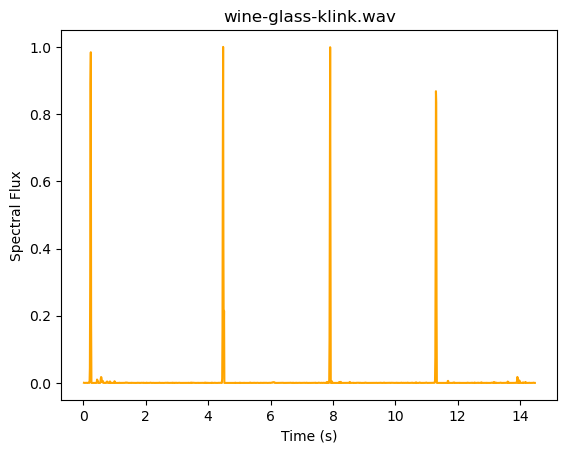

In [ ]:
# ys, ts, sr = helpers.get_audio_data(f"test_audio_files/wine-glass-klink.wav")
# ts_fr, fr_freq_amps = helpers.magnitudeSpectrogram(ys, ts, sr)
# ts_fr, spec_flux = helpers.computeSpectralFlux(ts_fr, fr_freq_amps, sr)
# plt.title("wine-glass-klink.wav")
# plt.xlabel("Time (s)"); plt.ylabel("Spectral Flux")
# plt.plot(ts_fr, spec_flux, c="orange")
# img_path = Path.cwd() / "spec_flux_graphs" / "wine-glass-klink.wav.png"
# # plt.xlim(0, 1)
# plt.savefig(img_path)